In [1]:
#Import necessary libraries
import h5py
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
from scipy.spatial import distance
from operator import itemgetter
from torchsummary import summary

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#SET SEEDS
random.seed(24)
np.random.seed(24)
torch.manual_seed(24)

In [3]:
movies_data_path = '/content/drive/MyDrive/Project/movies_data.hd5'
movies_data = h5py.File(movies_data_path,'r')

dataset_path = '/content/drive/MyDrive/Project/generated_data.hd5'
dataset  = h5py.File(dataset_path,'r')

cosine_weights_path = '/content/drive/MyDrive/Project/cosine_weights.hd5'
cosine_weights = h5py.File(cosine_weights_path, "r")

In [4]:
movies_vectors = movies_data['metadata'][:]
movies_id = movies_data['id'][:]
movies_title = movies_data['title'][:]

x_data = dataset['x_data'][:]
y_data = dataset['y_label'][:]
inp_combination = dataset['combination'][:]

w = cosine_weights['w'][:]

In [5]:
#Converting numpy to tensors
w = torch.from_numpy(w)
movies_vectors = torch.from_numpy(movies_vectors)
x_data = torch.from_numpy(x_data)
y_data = torch.from_numpy(y_data)
inp_combination = torch.from_numpy(inp_combination)

In [7]:
#Shuffle data
x_data,y_data,inp_combination = shuffle(x_data, y_data, inp_combination, random_state = 24)

In [9]:
#Split the data to train and validation
train_x = x_data[:99000]
train_id = inp_combination[:99000]
train_y = y_data[:99000]

validation_x = x_data[99000:]
validation_id = inp_combination[99000:]
validation_y = y_data[99000:]


In [10]:
def get_title(id):
  title_list = []

  for i in id:
    ind = np.where(movies_id == i)
    title = title = str(movies_title[ind])[2:-1]
    title_list.append(title)
  
  return title_list

In [11]:
def get_recommendation(combined_vector, id):
  vec = combined_vector.reshape((1,409))
  movie_list = {}

  for i in range(6716):
    if( (movies_id[i] != id[0]) and (movies_id[i] != id[1]) and (movies_id[i] != id[2])):
      mov = movies_vectors[i].reshape((409,1))
      cs = distance.cosine(vec,mov,w)
      title = str(movies_title[i])[2:-1]
      movie_list[title] = [cs,movies_id[i]]
  movie_list = dict(sorted(movie_list.items(), key = itemgetter(1), reverse = False)[:5])

  return movie_list

In [12]:
def output_recommendation(v,id):
  m = get_recommendation(v,id)
  names = get_title(id)
  print("============================")
  print('For movies :' ,names[0],names[1],names[2])
  print("Recommendation is: ",m.keys())

In [35]:
num_inputs = 409*3

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(num_inputs, 1000)
        self.hidden2 = nn.Linear(1000, 800)
        self.output = nn.Linear(800, 409)

    def forward(self, x):
        x = self.hidden1(x) 
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.output(x)
        return x

model = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
model.to(device);

print(device)

cuda:0


In [14]:
train_dataset = TensorDataset(train_x,train_y,train_id)
validation_dataset = TensorDataset(validation_x, validation_y, validation_id)

In [16]:
#Loading the test and train dataset
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True, num_workers=2)
val_loader = DataLoader(validation_dataset, batch_size=1,shuffle=False, num_workers=2)

In [36]:
summary(model, (1, 1, num_inputs))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 1, 1, 1000]       1,228,000
            Linear-2            [-1, 1, 1, 800]         800,800
            Linear-3            [-1, 1, 1, 409]         327,609
Total params: 2,356,409
Trainable params: 2,356,409
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 8.99
Estimated Total Size (MB): 9.01
----------------------------------------------------------------


In [37]:
loss_func = nn.MSELoss()
import torch.optim as optim
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-10)

num_epochs  = 10

# for generating plots
loss_list = []
iteration_list = []
similarity_list = []

count = 0
for epoch in range(num_epochs):

  for combined_vec,recommended_vec,idlist in train_loader:
    count += 1
    model.train()

    # Transfering images and labels to GPU if available
    combined_vec, recommended_vec = combined_vec.to(device) , recommended_vec.to(device).float()

    train = combined_vec.view(-1, num_inputs) 

    # Forward pass 
    outputs = model(train.float())
    
    loss = loss_func(recommended_vec, outputs)
    
    # back-prop
    optimizer.zero_grad()
    loss.backward()

    # optimize
    optimizer.step()

    if not(count % 1000):
      with torch.no_grad():
        cosine_distance = []
        c = 0
        for combined_vec,recommended_vec,idlist in val_loader:
          c+=1
          combined_vec, recommended_vec = combined_vec.to(device) , recommended_vec.to(device).float()
          model.eval()

          outputs = model(combined_vec.float()).cpu()
          predictions = outputs[:]

          np_preds = predictions.cpu().detach().numpy()
          rvec = recommended_vec.cpu().detach().numpy()

          if(c <= 5):
            id_list_np = idlist.cpu().detach().numpy()
            output_recommendation(np_preds,id_list_np[0])
            
          cs1 = distance.cosine(np_preds,rvec.T, w)
          cosine_distance.append(cs1)

              
          avg_cs = sum(cosine_distance)  / len(cosine_distance)
          
        loss_list.append(loss.cpu().data)
        iteration_list.append(count)
        similarity_list.append(avg_cs)

        print(f'Epoch: {epoch+1:02d}, Iteration: {count:5d}, Loss: {loss.data:.4f}') 
  torch.save(model,"model_relu_01.pt")   

print('Finished Training')

For movies : 'The Last House on Cemetery Lane' 'Poker Night' 'One Week'
Recommendation is:  dict_keys(['Snowtown', 'Children of the Corn', 'The Bleeding House', 'Found', 'Mischief Night'])
For movies : 'Teen Spirit' 'Burning Man' 'Step Brothers'
Recommendation is:  dict_keys(['Music Within', 'The Edge of Seventeen', 'Listen Up Philip', 'Kabluey', 'The Angriest Man in Brooklyn'])
For movies : 'Crystal Lake Memories: The Complete History of Friday the 13th' 'Mirror Mirror' 'Crystal Lake Memories: The Complete History of Friday the 13th'
Recommendation is:  dict_keys(['Man vs. Snake', 'Vegucated', 'With Great Power: The Stan Lee Story', 'Helvetica', 'Minimalism: A Documentary About the Important Things'])
For movies : 'California Solo' 'Middle School: The Worst Years of My Life' 'Skeletons'
Recommendation is:  dict_keys(['Music Within', 'The Edge of Seventeen', 'Speech & Debate', 'Listen Up Philip', 'Birds of America'])
For movies : 'Song One' 'Prowl' 'Marauders'
Recommendation is:  dict_

In [20]:
c=0
for i,j,k in val_loader:
  c+=1
  if(c<=5):
    x=k.numpy()
    print(x)
    output_recommendation(j,x[0])
  else:
    break

[[324986. 298093.  18635.]]
For movies : 'The Last House on Cemetery Lane' 'Poker Night' 'One Week'
Recommendation is:  dict_keys(['The Girl Next Door', 'Wrecker', 'Snowtown', 'Shuttle', 'Shark Swarm'])
[[73108. 73565. 12133.]]
For movies : 'Teen Spirit' 'Burning Man' 'Step Brothers'
Recommendation is:  dict_keys(['Birds of America', 'The Edge of Seventeen', 'Kabluey', 'Norman', 'Summer of 8'])
[[222724.  62764. 222724.]]
For movies : 'Crystal Lake Memories: The Complete History of Friday the 13th' 'Mirror Mirror' 'Crystal Lake Memories: The Complete History of Friday the 13th'
Recommendation is:  dict_keys(['Man vs. Snake', 'I Am Chris Farley', 'With Great Power: The Stan Lee Story', 'Bridegroom', 'I Am Evel Knievel'])
[[ 84180. 369883.  46909.]]
For movies : 'California Solo' 'Middle School: The Worst Years of My Life' 'Skeletons'
Recommendation is:  dict_keys(['Are We Done Yet?', 'Speech & Debate', 'True Confessions of a Hollywood Starlet', 'The Angriest Man in Brooklyn', 'Foster'])

In [ ]:
torch.save(model,"model.pt")

In [ ]:
model1 = torch.load("model.pt")

In [ ]:

i,j,k = 100,200,101
combined_vec = torch.cat((movies_vectors[i],movies_vectors[j],movies_vectors[k]),0)
combined_vec = combined_vec.to(device)
model1.eval()

outputs = model(combined_vec.float()).cpu()
print(outputs.size())
predictions = outputs[:]
print(predictions.shape)
np_preds = predictions.cpu().detach().numpy()
output_recommendation(np_preds,[movies_id[i],movies_id[j],movies_id[k]])

torch.Size([409])
torch.Size([409])
For movies : "Who's Your Caddy?" 'Be Kind Rewind' 'The Simpsons Movie'
Recommendation is:  dict_keys(['Music Within', 'The Edge of Seventeen', 'A Little Help', 'Speech & Debate', 'Growing Op'])


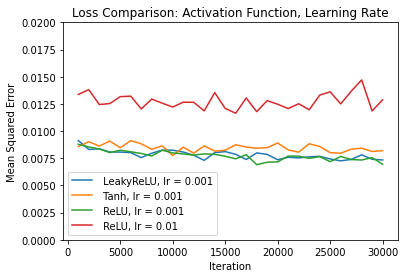

In [49]:
# plt.plot(iteration_list, leaky_loss_01, label=" LeakyReLU, lr = 0.01" )
plt.plot(iteration_list, leaky_loss_001, label=" LeakyReLU, lr = 0.001" )


plt.plot(iteration_list, loss_tanh, label=" Tanh, lr = 0.001" )
plt.plot(iteration_list, loss_relu_001, label=" ReLU, lr = 0.001" )
plt.plot(iteration_list, loss_relu_01, label=" ReLU, lr = 0.01" )
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.title("Loss Comparison: Activation Function, Learning Rate")
plt.ylim(0, 0.02)
plt.show()

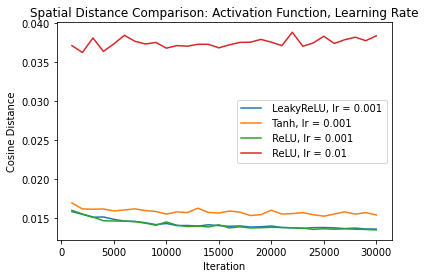

In [50]:
plt.plot(iteration_list, leaky_dist_001, label=" LeakyReLU, lr = 0.001" )


plt.plot(iteration_list, dist_tanh, label=" Tanh, lr = 0.001" )
plt.plot(iteration_list, dist_relu_001, label=" ReLU, lr = 0.001" )
plt.plot(iteration_list, dist_relu_01, label=" ReLU, lr = 0.01" )
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Cosine Distance")
plt.title("Spatial Distance Comparison: Activation Function, Learning Rate")
# plt.ylim(0, 0.02)
plt.show()